## **Contextual Bandit: Linear Upper Confidence Bound Disjoint (LinUCB Disjoint) Algorithm**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### **Data Preprocessing**
#### 1. User Data (covariates)

In [2]:
# read user data: user_id, age, gender, occupation

user = pd.read_csv('../dataset/ml-100k/u.user', header = None, sep = '|')
user.columns = ['user_id', 'age', 'gender', 'occupation', 'zipcode']
user = user.drop(['zipcode'], axis = 1)

In [3]:
# group user's age into bins

bins = [0, 20, 30, 40, 50, 60, np.inf]
names = ['<20', '20-29', '30-39', '40-49', '51-60', '60+']

user['age_group'] = pd.cut(user['age'], bins, labels=names)
user = user.drop(['age'], axis = 1)
user.head()

,user_id,gender,occupation,age_group
0,1,M,technician,20-29
1,2,F,other,51-60
2,3,M,writer,20-29
3,4,M,technician,20-29
4,5,F,other,30-39


In [4]:
# perform one hot encoding on categorical variables: age_group, gender, occupation

columnsToEncode = ['age_group', 'gender', 'occupation']
myEncoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
myEncoder.fit(user[columnsToEncode])

user_features = pd.concat([user.drop(columnsToEncode, 1),
                           pd.DataFrame(myEncoder.transform(user[columnsToEncode]), 
                           columns = myEncoder.get_feature_names_out(columnsToEncode))], axis=1).reindex()

In [5]:
user_features.head()

,user_id,age_group_20-29,age_group_30-39,age_group_40-49,age_group_51-60,age_group_60+,age_group_<20,gender_F,gender_M,occupation_administrator,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 2. Movies Data (arms)

In [6]:
# read movies data

movie = pd.read_csv('../dataset/ml-100k/u.item', header = None, sep = '|', encoding='latin-1')
movie.columns = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action',
                 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

In [7]:
# drop unused features

movie_features = movie.drop(['movie_title', 'release_date', 'video_release_date', 'IMDb_URL'], axis = 1)
movie_features.head()

,movie_id,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


#### 3. Ratings/Rewards Data

In [8]:
# read ratings data and drop timestamp column

data = pd.read_csv('../dataset/ml-100k/u.data', sep ='\t', header=None, names = ['user_id', 'movie_id','rating', 'timestamp'])
data = data.drop(['timestamp'], axis = 1)

In [9]:
# filter for top n movies

n = 30
top_movies_index = data.groupby('movie_id').count().sort_values('user_id', ascending = False).head(n).reset_index()['movie_id']
top_movies_features = movie_features[movie_features.movie_id.isin(top_movies_index)]
top_movies_features.to_numpy().shape

(30, 20)

In [10]:
filtered_data = data[data['movie_id'].isin(top_movies_index)]
filtered_data['reward'] = np.where(filtered_data['rating'] < 4, 0, 1)
filtered_data = filtered_data.reset_index(drop = True)
filtered_data.head()

C:\Users\toh_e\AppData\Local\Temp\ipykernel_10452\2414002179.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['reward'] = np.where(filtered_data['rating'] < 4, 0, 1)


,user_id,movie_id,rating,reward
0,200,222,5,1
1,308,1,4,1
2,301,98,4,1
3,251,100,4,1
4,25,181,5,1


### Functions for LinUCB Disjoint

In [11]:
# create class object for a single linear ucb disjoint arm

class linucb_disjoint_arm():
    
    def __init__(self, arm_index, d, alpha):
        self.arm_index = arm_index
        self.alpha = alpha
        self.A = np.identity(d)
        self.b = np.zeros([d,1])
        
    def calc_UCB(self, x_array):
        A_inv = np.linalg.inv(self.A)
        self.theta = np.dot(A_inv, self.b)
        p = np.dot(self.theta.T,x_array) +  self.alpha * np.sqrt(np.dot(x_array.T, np.dot(A_inv,x_array)))
        return p
    
    def reward_update(self, reward, x_array):
        self.A += np.dot(x_array, x_array.T)
        self.b += reward * x_array

In [12]:
class linucb_disjoint_policy():
    
    def __init__(self, K_arms, d, alpha):
        self.K_arms = K_arms
        self.linucb_arms = [linucb_disjoint_arm(arm_index = i, d = d, alpha = alpha) for i in range(K_arms)]
        
    def select_arm(self, x_array):
        highest_ucb = -1
        candidate_arms = []
        
        for arm_index in range(self.K_arms):
            arm_ucb = self.linucb_arms[arm_index].calc_UCB(x_array)
            if arm_ucb > highest_ucb:
                highest_ucb = arm_ucb
                candidate_arms = [arm_index]

            if arm_ucb == highest_ucb:
                candidate_arms.append(arm_index)
        
        chosen_arm = np.random.choice(candidate_arms)
        return chosen_arm
    
    def store_arm_index(self, arms_index_array):
        for i in range(self.K_arms):
            self.linucb_arms[i].arm_index = arms_index_array[i]

In [13]:
def disjoint_bootstrap_replay(K_arms, d, alpha, top_movies_index, bootstrap_resample):
    
    evaluation = []
    
    for b in range(1, bootstrap_resample+1): 
        linucb_disjoint_policy_object = linucb_disjoint_policy(K_arms = K_arms, d = d, alpha = alpha)
        linucb_disjoint_policy_object.store_arm_index(top_movies_index.to_numpy())

        step = 0

        for i in range(len(filtered_data)*n+1):
            bootstrap_sample = resample(filtered_data, replace=True, n_samples=1) # sample with replacement
            
            user_id = bootstrap_sample['user_id'].values[0]
            movie_id = bootstrap_sample['movie_id'].values[0]
            data_reward = bootstrap_sample['reward'].values[0]
            
            data_x_array = np.array(user_features.query("user_id == @user_id").drop("user_id", axis = 1))
            data_x_array = data_x_array.reshape(29,1)
            
            chosen_arm_index = linucb_disjoint_policy_object.select_arm(data_x_array)
            
            if linucb_disjoint_policy_object.linucb_arms[chosen_arm_index].arm_index  == movie_id:
                step += 1
                linucb_disjoint_policy_object.linucb_arms[chosen_arm_index].reward_update(data_reward, data_x_array)
                
                update = {'bootstrap_sample':b, 'policy':linucb_disjoint_policy_object, 'log_step':i, 'time_step':step, 'reward':data_reward}
                evaluation.append(update)
    
    return evaluation

### Functions for LinUCB Hybrid


In [14]:
# create class object for a single linear ucb hybrid arm

class linucb_hybrid_arm():
    
    def __init__(self, d, k, alpha):
        self.A = np.identity(d)
        self.B = np.zeros([d, k])
        self.b = np.zeros([d,1])
        self.alpha = alpha
        
    def init_arm_features(self, arm_index, arm_features_array):
        self.index = arm_index
        self.arm_features = arm_features_array
        
        
    def calc_UCB(self, x_array, A_node_inv, beta_hat):
        z_array = np.outer(self.arm_features, x_array).reshape(-1,1)
        A_inv = np.linalg.inv(self.A)
        self.theta = np.dot(A_inv, (self.b - np.dot(self.B, beta_hat)))
        
        s = np.dot(z_array.T, np.dot(A_node_inv, z_array)) \
            - 2 * np.dot(z_array.T, np.dot(A_node_inv, np.dot(self.B.T, np.dot(A_inv, x_array)))) \
            + np.dot(x_array.T, np.dot(A_inv, x_array)) \
            + np.dot(x_array.T, np.dot(A_inv, np.dot(self.B, np.dot(A_node_inv, np.dot(self.B.T, np.dot(A_inv, x_array))))))
        p = np.dot(z_array.T, beta_hat) + np.dot(x_array.T, self.theta) + self.alpha*np.sqrt(s)
        return p
    
    def reward_update(self, reward, x_array, z_array):
        self.A += np.dot(x_array, x_array.T)
        self.B += np.dot(x_array, z_array.T)
        self.b += reward * x_array  

In [15]:
class linucb_hybrid_policy():
    
    def __init__(self, K_arms, d, k, alpha):
        self.K_arms = K_arms
        self.linucb_arms = [linucb_hybrid_arm(d = d, k = k, alpha = alpha) for i in range(K_arms)]
        self.A_node = np.identity(k)
        self.b_node = np.zeros([k,1])
        
    def store_arm_features(self, arms_features_array):
        for i in range(self.K_arms):
            self.linucb_arms[i].init_arm_features(arm_index = arms_features_array[i,0], 
                                                  arm_features_array = arms_features_array[i,1:])
        
    def select_arm(self, x_array):
        highest_ucb = -1
        A_node_inv = np.linalg.inv(self.A_node)
        beta_hat = np.dot(A_node_inv, self.b_node)
        
        
        candidate_arms = []
        
        for arm_index in range(self.K_arms):
            arm_ucb = self.linucb_arms[arm_index].calc_UCB(x_array, A_node_inv, beta_hat)
            
            if arm_ucb > highest_ucb:
                highest_ucb = arm_ucb
                candidate_arms = [arm_index]

            if arm_ucb == highest_ucb:
                candidate_arms.append(arm_index)
        
        chosen_arm_index = np.random.choice(candidate_arms)
        return chosen_arm_index
    
    def update_shared_features_matrices_phase1(self, chosen_arm_B, chosen_arm_A, chosen_arm_b):
        chosen_arm_A_inv = np.linalg.inv(chosen_arm_A)
        self.A_node += np.dot(chosen_arm_B.T, np.dot(chosen_arm_A_inv, chosen_arm_B))
        self.b_node += np.dot(chosen_arm_B.T, np.dot(chosen_arm_A_inv, chosen_arm_b))
        
    def update_shared_features_matrices_phase2(self, z_array, reward, chosen_arm_B, chosen_arm_A, chosen_arm_b):
        chosen_arm_A_inv = np.linalg.inv(chosen_arm_A)
        self.A_node += np.dot(z_array, z_array.T) - np.dot(chosen_arm_B.T, np.dot(chosen_arm_A_inv, chosen_arm_B)) 
        self.b_node += reward * z_array - np.dot(chosen_arm_B.T, np.dot(chosen_arm_A_inv, chosen_arm_b))

In [16]:
def hybrid_bootstrap_replay(K_arms, d, k, alpha, top_movies_index, top_movies_features, bootstrap_resample):
    
    evaluation = []
    
    for b in range (1, bootstrap_resample+1):
        linucb_hybrid_policy_object = linucb_hybrid_policy(K_arms = K_arms, d = d, k = k, alpha = alpha)
        linucb_hybrid_policy_object.store_arm_features(top_movies_features.to_numpy())

        step = 0

        for i in range(len(filtered_data)*n+1):
            bootstrap_sample = resample(filtered_data, replace=True, n_samples=1)
            
            user_id = bootstrap_sample['user_id'].values[0]
            movie_id = bootstrap_sample['movie_id'].values[0]
            data_reward = bootstrap_sample['reward'].values[0]
            
            data_x_array = np.array(user_features.query("user_id == @user_id").drop("user_id", axis = 1)) # Shape (1 * 29), d = 29
            data_x_array = data_x_array.reshape(29,1)
            
            chosen_arm_index = linucb_hybrid_policy_object.select_arm(data_x_array)
            
            if linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].index  == movie_id:
                
                step += 1
                
                linucb_hybrid_policy_object.update_shared_features_matrices_phase1(linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].B,
                                                                                   linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].A,
                                                                                   linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].b)

                data_z_array = np.outer(linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].arm_features, data_x_array).reshape(-1,1)
                linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].reward_update(data_reward, data_x_array, data_z_array)

                linucb_hybrid_policy_object.update_shared_features_matrices_phase2(data_z_array,
                                                                                   data_reward,
                                                                                   linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].B,
                                                                                   linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].A,
                                                                                   linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].b)
                
                update = {'bootstrap_sample':b, 'policy':linucb_hybrid_policy_object, 'log_step':i, 'time_step':step, 'reward':data_reward}
                evaluation.append(update)
                
    return evaluation

### Run Replay for various Alpha Values

In [ ]:
# create 'results' folder to store all results

import os
if not os.path.exists('results'):
    os.makedirs('results')

In [17]:
# alpha = 0.25

disjoint_025 = disjoint_bootstrap_replay(K_arms=n, d=29, alpha=0.25, top_movies_index=top_movies_index, bootstrap_resample=3)
hybrid_025 = hybrid_bootstrap_replay(K_arms=n, d=29, k=29*19, alpha=0.25, top_movies_index=top_movies_index, top_movies_features=top_movies_features, bootstrap_resample=3)

In [18]:
disjoint_025_df = pd.DataFrame(disjoint_025)
disjoint_025_df = disjoint_025_df.sort_values(by=['bootstrap_sample', 'time_step'])
disjoint_025_df.to_csv("results/disjoint_025.csv")

hybrid_025_df = pd.DataFrame(hybrid_025)
hybrid_025_df = hybrid_025_df.sort_values(by=['bootstrap_sample', 'time_step'])
hybrid_025_df.to_csv("results/hybrid_025.csv")

In [19]:
# alpha = 0.5

disjoint_05 = disjoint_bootstrap_replay(K_arms=n, d=29, alpha=0.5, top_movies_index=top_movies_index, bootstrap_resample=3)
hybrid_05 = hybrid_bootstrap_replay(K_arms=n, d=29, k=29*19, alpha=0.5, top_movies_index=top_movies_index, top_movies_features=top_movies_features, bootstrap_resample=3)

In [20]:
disjoint_05_df = pd.DataFrame(disjoint_05)
disjoint_05_df = disjoint_05_df.sort_values(by=['bootstrap_sample', 'time_step'])
disjoint_05_df.to_csv("results/disjoint_05.csv")

hybrid_05_df = pd.DataFrame(hybrid_05)
hybrid_05_df = hybrid_05_df.sort_values(by=['bootstrap_sample', 'time_step'])
hybrid_05_df.to_csv("results/hybrid_05.csv")

In [21]:
# alpha = 1.0

disjoint_1 = disjoint_bootstrap_replay(K_arms=n, d=29, alpha=1.0, top_movies_index=top_movies_index, bootstrap_resample=3)
hybrid_1 = hybrid_bootstrap_replay(K_arms=n, d=29, k=29*19, alpha=1.0, top_movies_index=top_movies_index, top_movies_features=top_movies_features, bootstrap_resample=3)

In [23]:
disjoint_1_df = pd.DataFrame(disjoint_1)
disjoint_1_df = disjoint_1_df.sort_values(by=['bootstrap_sample', 'time_step'])
disjoint_1_df.to_csv("results/disjoint_1.csv")

hybrid_1_df = pd.DataFrame(hybrid_1)
hybrid_1_df = hybrid_1_df.sort_values(by=['bootstrap_sample', 'time_step'])
hybrid_1_df.to_csv("results/hybrid_1.csv")

### Aggregate & Plot Results

* results for LinUCB Disjoint vs LinUCB Hybrid

In [23]:
disjoint_025 = pd.read_csv('results/disjoint_025.csv', index_col=0)
disjoint_025['policy'] = 'disjoint, alpha=0.25'

disjoint_05 = pd.read_csv('results/disjoint_05.csv', index_col=0)
disjoint_05['policy'] = 'disjoint, alpha=0.5'

disjoint_1 = pd.read_csv('results/disjoint_1.csv', index_col=0)
disjoint_1['policy'] = 'disjoint, alpha=1.0'

hybrid_025 = pd.read_csv('results/hybrid_025.csv', index_col=0)
hybrid_025['policy'] = 'hybrid, alpha=0.25'

hybrid_05 = pd.read_csv('results/hybrid_05.csv', index_col=0)
hybrid_05['policy'] = 'hybrid, alpha=0.5'

hybrid_1 = pd.read_csv('results/hybrid_1.csv', index_col=0)
hybrid_1['policy'] = 'hybrid, alpha=1.0'

results_UCB = pd.concat([disjoint_025, disjoint_05, disjoint_1, hybrid_025, hybrid_05, hybrid_1], axis=0)
results_UCB.head()

,bootstrap_sample,policy,log_step,time_step,reward
0,1,"disjoint, alpha=0.25",39,1,0
1,1,"disjoint, alpha=0.25",80,2,1
2,1,"disjoint, alpha=0.25",81,3,1
3,1,"disjoint, alpha=0.25",110,4,1
4,1,"disjoint, alpha=0.25",241,5,0


In [24]:
UCB_rewards = results_UCB.groupby(['policy', 'time_step'])['reward'].mean()
UCB_rewards = UCB_rewards.reset_index()
UCB_rewards['cumulative_rewards'] = UCB_rewards.groupby(['policy'])['reward'].cumsum()

(0.0, 9000.0)

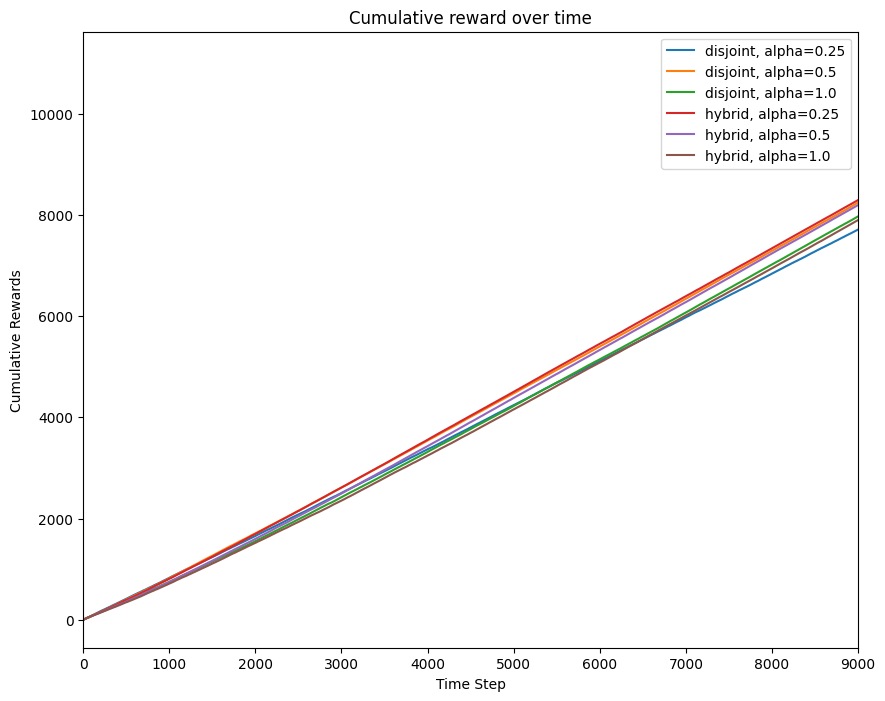

In [25]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

for f in results_UCB['policy'].unique():
    results = UCB_rewards[UCB_rewards['policy']==f]
    ax.plot(results['time_step'], results['cumulative_rewards'], label=f)
plt.legend()
plt.title("Cumulative reward over time")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Rewards")
plt.xlim([0, 9000])

* combined results of Epsilon Decay & Contextual Bandit

In [3]:
disjoint_05 = pd.read_csv('../results/disjoint_05.csv', index_col=0)
disjoint_05['policy'] = 'disjoint, alpha=0.5'

hybrid_025 = pd.read_csv('../results/hybrid_025.csv', index_col=0)
hybrid_025['policy'] = 'hybrid, alpha=0.25'

epsilon_decay = pd.read_csv('../results/epsilon_decay.csv')
epsilon_decay = epsilon_decay[epsilon_decay['policy'] == 'epsilon_decay_k_25']

epsilon_decay.loc[epsilon_decay['policy'] == 'epsilon_decay_k_25', 'policy'] = 'epsilon_decay, k=25'
epsilon_decay = epsilon_decay.drop(['cumulative_rewards', 'chosen_arm'], axis='columns')

results = pd.concat([disjoint_05, hybrid_025, epsilon_decay], axis=0)
results

,bootstrap_sample,policy,log_step,time_step,reward,Unnamed: 0
0,1,"disjoint, alpha=0.5",16,1,1,NaN
1,1,"disjoint, alpha=0.5",23,2,1,NaN
2,1,"disjoint, alpha=0.5",86,3,1,NaN
3,1,"disjoint, alpha=0.5",88,4,1,NaN
4,1,"disjoint, alpha=0.5",97,5,1,NaN
...,...,...,...,...,...,...
105293,3,"epsilon_decay, k=25",359609,11004,1,33138.0
105294,3,"epsilon_decay, k=25",359634,11005,0,33139.0
105295,3,"epsilon_decay, k=25",359641,11006,1,33140.0
105296,3,"epsilon_decay, k=25",359775,11007,1,33141.0


In [4]:
overall_rewards = results.groupby(['policy', 'time_step'])['reward'].mean()
overall_rewards = overall_rewards.reset_index()
overall_rewards['cumulative_rewards'] = overall_rewards.groupby(['policy'])['reward'].cumsum()

(0.0, 9000.0)

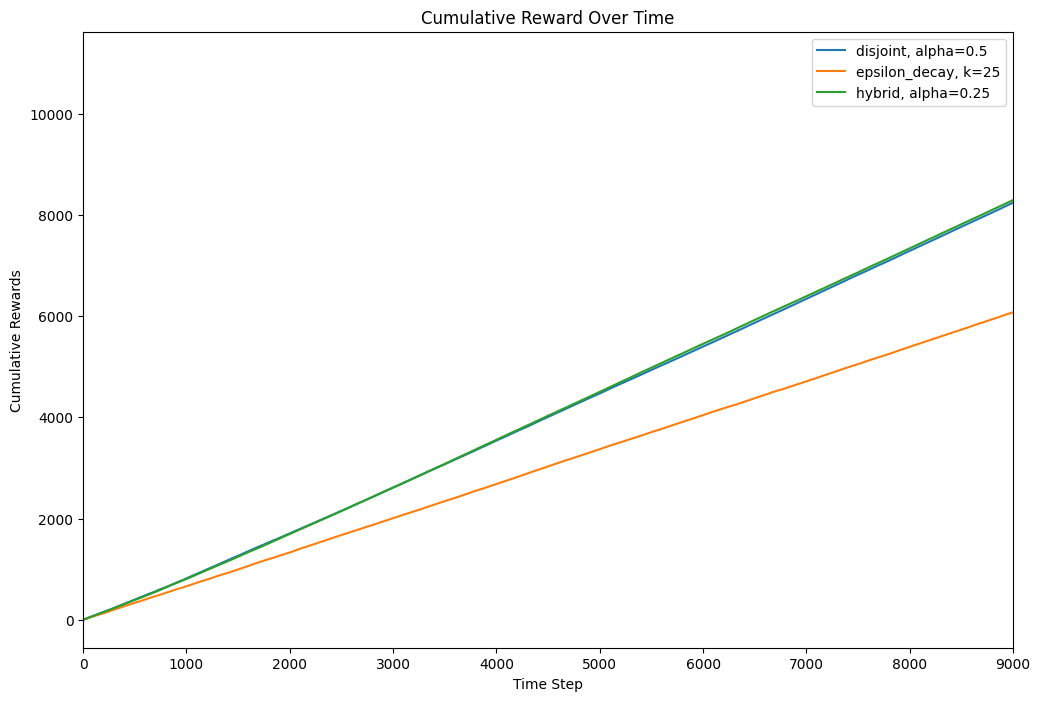

In [5]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

for f in overall_rewards['policy'].unique():
    result = overall_rewards[overall_rewards['policy']==f]
    ax.plot(result['time_step'], result['cumulative_rewards'], label=f)
plt.legend()
plt.title("Cumulative Reward Over Time")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Rewards")
plt.xlim([0, 9000])